# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "/content/assignment3"
# if not os.path.exists(datadir):
#   !ln -s "/content/drive/assignment3/" $datadir # TODO: Fill your Assignment 3 path
# os.chdir(datadir)
# !pwd

# Data Setup


The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image


def rotate_img(img, rot):
    """Rotate an image by 0, 90, 180, or 270 degrees."""
    # print(rot)
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 1:  # 90 degrees rotation
        return torch.rot90(img, 1, [1, 2])
    elif rot == 2:  # 180 degrees rotation
        return torch.rot90(img, 2, [1, 2])  # Rotate 90 degrees twice
    elif rot == 3:  # 270 degrees rotation
        return torch.rot90(img, 3, [1, 2])  # Rotate 90 degrees three times
    else:
        raise ValueError('rotation should be 0, 1, 2, or 3')



class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)
        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)


        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()


In [27]:
# from cifar10rotation import CIFAR10Rotation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


### Show some example images and rotated images with labels:

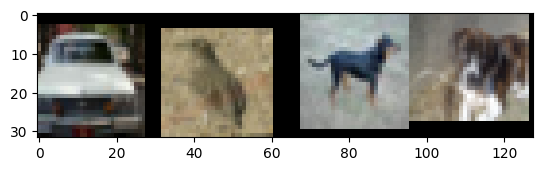

Class labels:  car   bird  dog   dog  


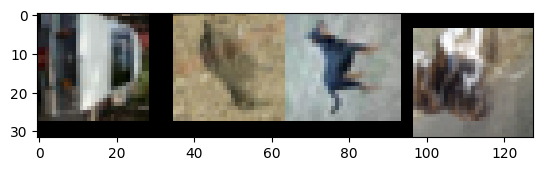

Rotation labels:  270   180   90    180  


In [28]:
import matplotlib.pyplot as plt
# from cifar10rotation import CIFAR10Rotation

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
# print(next(dataiter))
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [29]:
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def run_test(net, testloader, criterion, task):
    correct = 0

    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            else:
                raise ValueError("Task must be 'rotation' or 'classification'.")
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            outputs = net(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            avg_test_loss += loss.item() / len(testloader)

            # Determine predictions (highest output scores)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate and print accuracy and average loss
            accuracy = 100 * correct / total

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [30]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [32]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [33]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [34]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.
import traceback
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError("Task must be 'rotation' or 'classification'.")

            # TODO: Zero the parameter gradients

            try:
                optimizer.zero_grad()

                # TODO: forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
            except RuntimeError as e:
                print(f"Caught a RuntimeError: {e}")
                print(traceback.format_exc())  # This will print the full traceback
                print("Last CUDA error:", torch.cuda.get_last_error())  # Gives the last error on the CUDA side
                print("Detailed CUDA error stack:", torch.cuda.get_device_properties(0))  # Gives details about the CUDA error stack
                exit(1)  # Exit after printing the diagnostics


            # TODO: Get predicted results
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            # predicted = None

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

        #

    print('Finished Training')

In [35]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net, 'rotation_task_model_full.pth')

[1,   100] loss: 3.036 acc: 34.73 time: 8.60
[1,   200] loss: 2.500 acc: 44.95 time: 6.16
[1,   300] loss: 2.324 acc: 48.74 time: 7.22
TESTING:
Accuracy of the network on the 10000 test images: 52.71 %
Average loss on the 10000 test images: 2.155
[2,   100] loss: 2.186 acc: 52.46 time: 8.23
[2,   200] loss: 2.184 acc: 52.81 time: 7.16
[2,   300] loss: 2.145 acc: 53.30 time: 6.03
TESTING:
Accuracy of the network on the 10000 test images: 56.23 %
Average loss on the 10000 test images: 2.046
[3,   100] loss: 2.096 acc: 55.44 time: 7.15
[3,   200] loss: 2.047 acc: 56.20 time: 7.06
[3,   300] loss: 2.046 acc: 56.59 time: 6.07
TESTING:
Accuracy of the network on the 10000 test images: 59.11 %
Average loss on the 10000 test images: 1.973
[4,   100] loss: 1.953 acc: 58.77 time: 8.17
[4,   200] loss: 1.945 acc: 58.69 time: 6.06
[4,   300] loss: 1.940 acc: 58.90 time: 7.01
TESTING:
Accuracy of the network on the 10000 test images: 61.49 %
Average loss on the 10000 test images: 1.854
[5,   100] l

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

# Load the pre-trained ResNet18 model
model = resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes in your dataset if necessary
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))
model = model.to(device)


cuda
NVIDIA GeForce RTX 3060 Ti


c:\Users\vaibh\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vaibh\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the 'layer4' block
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze the parameters in the 'fc' layer
for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
# Print all the trainable parameters
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()

# Alternatively, you can use a different optimizer, such as Adam
optimizer = optim.Adam(params_to_update, lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [ ]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1 for detailed error messages and synchronous kernel execution
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(model, 'Fine_tuning_on_the_pre_trained_model.pth')

[1,   100] loss: 3.694 acc: 43.87 time: 30.82
[1,   200] loss: 2.629 acc: 56.16 time: 1.06
[1,   300] loss: 2.454 acc: 58.86 time: 1.07
TESTING:
Accuracy of the network on the 10000 test images: 62.39 %
Average loss on the 10000 test images: 2.193
[2,   100] loss: 2.227 acc: 61.11 time: 30.17
[2,   200] loss: 2.199 acc: 62.37 time: 1.06
[2,   300] loss: 2.207 acc: 62.41 time: 1.07
TESTING:
Accuracy of the network on the 10000 test images: 65.31 %
Average loss on the 10000 test images: 2.013
[3,   100] loss: 2.103 acc: 63.59 time: 30.18
[3,   200] loss: 2.065 acc: 63.66 time: 1.04
[3,   300] loss: 2.041 acc: 64.20 time: 1.07
TESTING:
Accuracy of the network on the 10000 test images: 64.78 %
Average loss on the 10000 test images: 2.031
[4,   100] loss: 1.944 acc: 65.72 time: 30.16
[4,   200] loss: 1.971 acc: 65.57 time: 1.05
[4,   300] loss: 1.953 acc: 65.70 time: 1.04
TESTING:
Accuracy of the network on the 10000 test images: 65.62 %
Average loss on the 10000 test images: 1.971
[5,   10

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [47]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)

# Modify the final fully connected layer to match the number of classes in your dataset if necessary
num_ftrs = net.fc.in_features
num_classes = 10  # Update this to the number of classes in your dataset
net.fc = nn.Linear(num_ftrs, num_classes)
net.to(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [48]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the 'layer4' block
for param in net.layer4.parameters():
    param.requires_grad = True

# Unfreeze the parameters in the 'fc' layer
for param in net.fc.parameters():
    param.requires_grad = True


In [49]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [50]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.001)

In [51]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 4.475 acc: 24.88 time: 8.03
[1,   200] loss: 3.812 acc: 29.94 time: 6.16
[1,   300] loss: 3.683 acc: 33.41 time: 6.90
TESTING:
Accuracy of the network on the 10000 test images: 37.65 %
Average loss on the 10000 test images: 3.456
[2,   100] loss: 3.569 acc: 34.77 time: 6.87
[2,   200] loss: 3.539 acc: 35.54 time: 7.16
[2,   300] loss: 3.545 acc: 35.75 time: 5.74
TESTING:
Accuracy of the network on the 10000 test images: 39.14 %
Average loss on the 10000 test images: 3.376
[3,   100] loss: 3.475 acc: 36.95 time: 6.81
[3,   200] loss: 3.466 acc: 37.49 time: 7.02
[3,   300] loss: 3.469 acc: 37.40 time: 5.76
TESTING:
Accuracy of the network on the 10000 test images: 40.35 %
Average loss on the 10000 test images: 3.314
[4,   100] loss: 3.397 acc: 38.62 time: 8.09
[4,   200] loss: 3.393 acc: 39.48 time: 5.88
[4,   300] loss: 3.430 acc: 37.84 time: 6.90
TESTING:
Accuracy of the network on the 10000 test images: 40.48 %
Average loss on the 10000 test images: 3.276
[5,   100] l

In [52]:
torch.save(net, 'Fine_tuning_on_the_randomlly_model.pth')

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(pretrained=True)

num_classes = 10

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))
net.to(device)

cuda
Tesla T4


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [19]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net, 'Supervised_training_on_pretrained.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1,   100] loss: 5.042 acc: 17.23 time: 8.61
[1,   200] loss: 4.101 acc: 28.41 time: 8.15
[1,   300] loss: 3.891 acc: 31.05 time: 6.06
TESTING:
Accuracy of the network on the 10000 test images: 36.85 %
Average loss on the 10000 test images: 11.130
[2,   100] loss: 3.542 acc: 37.56 time: 8.27
[2,   200] loss: 3.167 acc: 40.56 time: 6.35
[2,   300] loss: 3.079 acc: 43.42 time: 7.27
TESTING:
Accuracy of the network on the 10000 test images: 46.66 %
Average loss on the 10000 test images: 2.993
[3,   100] loss: 2.769 acc: 48.71 time: 7.31
[3,   200] loss: 2.661 acc: 51.39 time: 7.44
[3,   300] loss: 2.553 acc: 53.38 time: 6.21
TESTING:
Accuracy of the network on the 10000 test images: 55.28 %
Average loss on the 10000 test images: 3.025
[4,   100] loss: 2.407 acc: 56.52 time: 9.19
[4,   200] loss: 2.278 acc: 58.95 time: 6.36
[4,   300] loss: 2.311 acc: 59.02 time: 7.28
TESTING:
Accuracy of the network on the 10000 test images: 58.10 %
Average loss on the 10000 test images: 2.467
[5,   100] 

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)

num_classes = 10

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [25]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net, 'Supervised_training_on_randomly.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1,   100] loss: 4.387 acc: 23.96 time: 10.81
[1,   200] loss: 3.788 acc: 30.57 time: 9.09
[1,   300] loss: 3.486 acc: 36.07 time: 6.19
TESTING:
Accuracy of the network on the 10000 test images: 41.39 %
Average loss on the 10000 test images: 3.390
[2,   100] loss: 3.214 acc: 40.48 time: 8.39
[2,   200] loss: 3.008 acc: 44.33 time: 6.15
[2,   300] loss: 2.849 acc: 47.68 time: 7.13
TESTING:
Accuracy of the network on the 10000 test images: 52.24 %
Average loss on the 10000 test images: 2.625
[3,   100] loss: 2.636 acc: 52.31 time: 8.17
[3,   200] loss: 2.527 acc: 54.70 time: 7.02
[3,   300] loss: 2.429 acc: 56.65 time: 6.66
TESTING:
Accuracy of the network on the 10000 test images: 57.75 %
Average loss on the 10000 test images: 2.549
[4,   100] loss: 2.253 acc: 59.88 time: 7.38
[4,   200] loss: 2.196 acc: 60.63 time: 7.49
[4,   300] loss: 2.147 acc: 61.69 time: 7.12
TESTING:
Accuracy of the network on the 10000 test images: 63.88 %
Average loss on the 10000 test images: 2.057
[5,   100] 

In [ ]:
supervised_model = resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(supervised_model.parameters(), lr=0.001)
supervised_model_acc = train(supervised_model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

plt.plot(range(1, 21), supervised_model_acc, label='Supervised CIFAR-10')
plt.plot(range(1, 21), rotnet_model_acc, label='RotNet fine-tuned on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs Epoch')
plt.legend()
plt.show()